# SARIG Geochemistry Data Entry Errors Analysis
 
## Author: Michael Rodda - Caldera Analytics


<i> So a notebook that has the Data Entry Errors in its title - possibly the most boring title for a notebook on the topic that is mind numbingly dull at the best of times. But data quality is critical for data science, so why should you care? </i>

The geochemistry datasets through the states of Australia are massive datasets that have accumulated assay results over the past 40+ years. Although the majority of the data is correct, there are numerous data entry errors that are scattered throughout these datasets. In the past, it is my assumption that obvious data entry errors have been cleaned up on the local scale by Exploration companies utilising historical assay data in their desktop studies. 

However with the rise of data science and the need to use millions of rows of data at once for the machine learning algorithms, data entry errors have the potential to cause big headaches at the state level, destabilise model training and <b>conceal valuable anomalous levels of desired metals</b>. 

Typically, the approach to deal with data entry errors would be to drop the most obvious outliers, but this is not a good approach, as the outliers in these geochemistry datasets are a mixture of data entry errors and <i> assay results belonging to deposits/mines</i>, which are outliers by definition.

The primary purpose of this notebook is to explore the data entry errors common in state geochemistry datasets, come up with a strategy to deal with these errors and attempt to hunt down the errors smarter and more efficiently. This notebook is based on the SARIG geochemistry dataset, utilising the extract done for the ExplorerSA competition.


This notebook has four sections:

1 - Wrangling the databases into a format better for data science/analysis

2 - Looking for and documenting errors that were found

3 - Coming up with better ways to hunt outliers

4 - Summarising the type of errors, root causes and strategies to improve the data quality

Because this notebook morphed into something massive, you can probably skip to the second section if you're only interested in data entry errors.










# Section One -  Format Conversion

In this section, we convert the geochemistry data into three seperate tables

#### Collars (locs)

Table that contains information about the collar such as location, depth, name, azimuth and depth


#### Samples (samples)

Table that contains information about the samples (sample id, downhole depth start of sample), downhole depth end of sample)

#### Assays (assays)

Table that contains information about the assay, such as what element, what was the assay result, what was the original unit and what was the lab method used for the assay.



Our focus is on the downhole geochemistry, rather than the surface chemistry.


The first step is to load the csv file that contains information about the collars such as location, azimuth etc.

<b> Note: From past experience, loading geo data with default settings in pandas can cause some rounding errors with latitude and longitudes - round_trip for float_precision seems to fix that </b>

In [1]:
import pandas as pd
import numpy as np

locs = pd.read_csv('sarig_dh_details_exp.csv',
                 encoding='cp1252',
                 low_memory=False,
                 float_precision='round_trip') 

locs.head()

,DRILLHOLE_NO,DH_NAME,DH_OTHER_NAME,PACE_DH,PACE_ROUND_NO,REPRESENTATIVE_DH,REPRESENTATIVE_DH_COMMENTS,DH_UNIT_NO,MAX_DRILLED_DEPTH,MAX_DRILLED_DEPTH_DATE,...,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,HORIZ_ACCRCY_M,ELEVATION_M,INCLINATION,AZIMUTH,SURVEY_METHOD_CODE,SURVEY_METHOD
0,1,GINGERAH HILL 1,NaN,N,NaN,N,NaN,3359 1,1473.50,14/09/1986,...,122.366742,-19.469838,122.366734,-19.469824,NaN,NaN,NaN,NaN,NaN,NaN
1,2,BROOKE 1,NaN,N,NaN,N,NaN,3458 1,2035.10,21/07/1988,...,122.916370,-19.749266,122.916362,-19.749252,NaN,NaN,NaN,NaN,NaN,NaN
2,3,SAHARA 1,NaN,N,NaN,N,NaN,3555 1,2120.19,26/02/1965,...,123.392991,-21.026384,123.392983,-21.026370,200.0,NaN,NaN,NaN,MAP,Map Plot
3,4,NYALAYI 1/90,NaN,N,NaN,N,NaN,3743 1,96.00,06/12/1990,...,124.485432,-27.189890,124.485424,-27.189876,NaN,NaN,NaN,NaN,NaN,NaN
4,5,GAMBANGA 1,NaN,N,NaN,N,NaN,3833 1,391.06,05/03/1960,...,124.743123,-32.290334,124.743116,-32.290320,NaN,NaN,NaN,NaN,NaN,NaN


We have two choices of location data - GDA94 and GDA2020. GDA2020 is chosen as the more recent holes are null for GDA94. The primary key for this table is DRILLHOLE_NO - this is appended with SA in case other states data is used at a later stage.

In [2]:
# Keep only relevant data
locs = locs[['DRILLHOLE_NO', 'DH_NAME',
            'MAX_DRILLED_DEPTH', 'MAX_DRILLED_DEPTH_DATE',
            'LONGITUDE_GDA2020', 'LATITUDE_GDA2020',
            'INCLINATION', 'AZIMUTH']]

locs.columns = ['collar_id', 'collar_name', 'max_depth', 'date_drilled',
               'lon', 'lat', 'dip', 'azi']

locs['collar_id'] = locs['collar_id'].astype(str) + '_SA'

The reference csv is loaded and joined to the collar dataframe as this contains the ID (Usually ENV xxxxx) to the source documents. This will be needed later when potential data entry errors are cross referenced.

In [3]:
loc_refs = pd.read_csv('sarig_dh_reference_exp.csv',
                 encoding='cp1252',
                 low_memory=False,
                 float_precision='round_trip')

loc_refs = loc_refs[['DRILLHOLE_NO', 'REFERENCE']].drop_duplicates()
loc_refs.columns = ['collar_id', 'reference']
loc_refs['collar_id'] = loc_refs['collar_id'].astype(str) + '_SA'

The reference data is not in a 1:1 relationship with the drillhole location. A hacky way is to take the last row for each collar_id, with the assumption that this will be the reference id to the most recent documentation, and therefore the most recent and up to date data.

In [4]:
loc_refs = loc_refs.groupby('collar_id').tail(1)
locs = locs.merge(loc_refs, 
                  how = 'left', 
                  validate = '1:1',
                  on = 'collar_id')

Now the geochemistry data is loaded in. Unfortunately the SARIG data has all the downhole and surface geochem merged into one file, so these needed to be pulled apart.

In [5]:
rs = pd.read_csv('sarig_rs_chem_exp.csv',
           low_memory=False)
rs.head()

,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHO_CODE,LITHO_CONF,LITHOLOGY_NAME,LITHO_MODIFIER,MAP_SYMBOL,...,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC
0,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,...,-27.069759,158,NaN,GEOCHEMISTRY,NaN,Ti,0.15,%,AES,AES
1,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,...,-27.069759,158,NaN,GEOCHEMISTRY,NaN,Ag,500,ppb,AES,AES
2,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,...,-27.069759,158,NaN,GEOCHEMISTRY,NaN,Ba,1200,ppm,AES,AES
3,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,...,-27.069759,158,NaN,GEOCHEMISTRY,NaN,Co,2,ppm,AES,AES
4,589,RO,Rock outcrop / float,SSA,Sediment Siliciclastic Arenite,SDST,NaN,Sandstone,NaN,NaN,...,-27.069759,158,NaN,GEOCHEMISTRY,NaN,Cr,1000,ppm,AES,AES


With sample source we can roughly see the type of geochemistry assay.

In [6]:
rs['SAMPLE_SOURCE'].value_counts()

Drill cuttings                                                  10956887
Sawn half drill core                                             7256976
Drill core                                                       6533477
Calcrete                                                         2154614
Soil                                                              989296
Drilled interval rock sample, type unspecified                    970508
Rock outcrop / float                                              537537
Sawn quarter drill core                                           237103
Drillhole log data - used in calculating values                   212746
Stream sediment                                                   164251
Auger sample from near surface                                    105514
Vegetation                                                         71018
Core sludge                                                        56217
A full face slice of core                          

The quick and effective way to seperate is to look at if there is a corresponding collar id in the geochemistry data. Keep only the ones that do.

In [7]:
rs = rs[~(rs['DRILLHOLE_NUMBER'].isnull()) &
   ~(rs['DH_NAME'].isnull())]

# Do some minor wrangling
# Keep the relevant columns
rs = rs[['SAMPLE_NO', 'SAMPLE_SOURCE', 'DRILLHOLE_NUMBER',
    'DH_DEPTH_FROM', 'DH_DEPTH_TO', 'CHEM_CODE', 'VALUE', 'UNIT',
    'CHEM_METHOD_CODE']]

# Change the sample and collar ids to our format that requires the state to be appended to the end
rs['SAMPLE_NO'] = rs['SAMPLE_NO'].astype('int').astype('str') + '_SA'
rs['DRILLHOLE_NUMBER'] = rs['DRILLHOLE_NUMBER'].astype('int').astype('str') + '_SA'

As per the target format of having three seperate tables of collars, samples and assays, the rs dataframe is split into samples and assays.

Samples contains:
- Sample ID
- Sample Name
- Drillhole Name
- Drillhole Number
- Start of sample (Downhole depth)
- End of sample (Downhole depth)

Assays contains:
- Sample ID
- Element
- Unit (ppm/ppb)
- Lab method
- Result

In [8]:
samples = rs[['SAMPLE_NO', 'SAMPLE_SOURCE', 'DRILLHOLE_NUMBER',
              'DH_DEPTH_FROM', 'DH_DEPTH_TO']].drop_duplicates()

assays = rs[['SAMPLE_NO', 'CHEM_CODE', 'VALUE', 'UNIT', 'CHEM_METHOD_CODE']].drop_duplicates()

del rs

## 1.1 - Assay Cleaning

The assay results need some standardisation:

- Some elements are listed as oxides. As the majority of assay results are for the base element, any oxide assay results are converted to their base element.

- Assay results are in different units. These needs to be standardised to ppm to be in an appropriate format for data analysis.

The unit standardisation is dealt with first. What units are present?

In [9]:
assays['UNIT'].value_counts()

ppm    19923316
%       6089681
ppb      292301
g/T       41321
cps        3632
Name: UNIT, dtype: int64

Before any conversion happens, the result column has to be converted into a numeric format, but cant be done yet because there are numerous assay results with > or < in them, denoting a result that is above  or below the detection limit of the lab method.

For the following cases:
- String starts with > (Above Detection limit): Drop the >
- String starts with < (Less than detection limit): Drop the <, set to zero.

The method for dealing with the below detection limit is not ideal. Theoretically the assay result is going to sit somewhere between 0 and the lower detection limit of the assay, so this should be kept in mind as our method will alter the means and medians. Possible workarounds would be to get the lower detection limit of each assay and take a random number between 0 and the lower limit, but this would be a lot of manual work and is outside of the scope of the notebook.

Once the data is converted into number format, any assay value in the negatives is also converted to 0, as this usually means a below detection limit / trace value.

In [10]:
assays['isUDL'] = np.where(assays['VALUE'].str.contains('>'), 1, 0)

assays['VALUE'] = assays['VALUE'].str.replace('>', '')

assays.loc[assays['VALUE'].str.contains('<'), 'VALUE'] = 0
assays['VALUE'] = pd.to_numeric(assays['VALUE'])
assays.loc[assays['VALUE'] < 0, 'VALUE'] = 0

Now the assay data can be standardised to ppm:

- ppb is divided by 1000
- percents are multiplied by 10000
- g/t is left the same
- cps is associated with Uranium assays and are considered outside the scope of the notebook.

The original unit is kept for error checking.

In [11]:
assays.loc[assays['UNIT'] == 'ppb', 'VALUE'] = assays.loc[assays['UNIT'] == 'ppb', 'VALUE'] / 1000
assays.loc[assays['UNIT'] == '%', 'VALUE'] = assays.loc[assays['UNIT'] == '%', 'VALUE'] * 10000
assays = assays[assays['UNIT'] != 'cps']  #Uranium
assays = assays.rename({'UNIT': 'old_unit'}, axis = 1)

In [12]:
assays

,SAMPLE_NO,CHEM_CODE,VALUE,old_unit,CHEM_METHOD_CODE,isUDL
14,2078806_SA,U3O8,5.0,ppm,XRF1,0
37,2078802_SA,U3O8,5.0,ppm,XRF1,0
38,2078803_SA,U3O8,5.0,ppm,XRF1,0
39,2078804_SA,U3O8,5.0,ppm,XRF1,0
40,2078805_SA,U3O8,5.0,ppm,XRF1,0
...,...,...,...,...,...,...
30445423,2979044_SA,Te,0.1,ppm,IC1M,0
30445424,2979044_SA,Tl,0.5,ppm,IC1M,0
30445425,2979044_SA,Tm,0.5,ppm,IC4R,0
30445426,2979044_SA,Yb,5.0,ppm,IC4R,0


Now for element conversion. The following needs to be done:

- Drop weird elements
- Convert Oxides to their Base Element

What needs to be dropped? The 50 least common values in the element column are shown below.

In [13]:
print(assays['CHEM_CODE'].value_counts()[-50:])

Gd           93845
Er           93638
Tm           93600
Ho           93558
Li           65813
MnO          64472
Cl           60273
Re           55325
Fe2O3        55298
Ge           44285
Hg           34945
Cr2O3        32438
CO2          31789
B            31251
V2O5         20903
F            15161
SO3          11794
BaO           7307
Total         6618
SrO           2986
FeO           2964
NiO           2593
ZrO2          2593
ZnO           2593
CoO           2593
C             1521
ThO2           549
Ru             439
WO3            394
Nb2O5          362
Ta2O5          358
TOT/C          357
TOT/S          351
CaCO3          251
Ir             182
Br             181
GPSM           153
H2O_minus      144
MgCO3          138
H2O_plus       132
Insol           90
GoI             65
Rh              63
Os              60
CO3             57
NaCl            56
H2O             54
SO4              4
Sr87_86          3
CaSO4            3
Name: CHEM_CODE, dtype: int64


In [14]:
elements_to_keep = ['B', 'S', 'U', 'P', 'Si',  'Au', 'Cu', 'Zn', 'Pb', 'Ag', 'As', 'Fe', 'Ni',
                    'Mn', 'Co', 'Mo', 'Bi', 'Cr', 'La', 'Ce', 'Mg',
                   'Ba', 'K', 'Ca', 'V', 'Sb', 'Na', 'Sr', 'Ti', 'Th',
                   'Al', 'Cd', 'Y', 'W', 'Sc', 'Ga', 'Zr', 'Tl', 'Be',
                   'Sn', 'Se', 'Te', 'Nb', 'Rb', 'Cs', 'Ta', 'Pd', 'In',
                   'Pt', 'Hf', 'Nd', 'Yb', 'Sm', 'Pr', 'Lu', 'Tb', 'Dy',
                   'Eu', 'Gd', 'Er', 'Tm', 'Ho', 'Li', 'Re', 'Ge', 'Hg',
                   'Ru', 'Ir', 'Rh', 'Os', 'F']
oxides_to_convert = ['MgO', 'CaO', 'Al2O3', 'TiO2', 'K2O', 'Na2O', 'MnO',
                     'Fe2O3', 'V2O5', 'Cr2O3', 'Nb2O5', 'ZnO', 'NiO', 'ThO2',
                    'WO3', 'BaO', 'Ta2O5', 'U3O8', 'P2O5', 'SiO2', 'FeO', 'SrO']

print("Old Length: {}".format(len(assays)))
assays = assays[assays['CHEM_CODE'].isin(elements_to_keep + oxides_to_convert)]
print("New Length after dropping non-compliant elements: {}".format(len(assays)))


Old Length: 26346619
New Length after dropping non-compliant elements: 25874780


Now the oxides are converted to their base elements and multiplied by the required molar mass difference.

In [ ]:
from geochem_utils import *

#Convert our oxides
assays = clean_oxides(assays, 'CHEM_CODE', 'VALUE')

The final step is to rename the column names to the same format.

In [16]:
samples.columns = ['sample_id', 'sample_source', 'collar_id', 'from', 'to']
assays.columns = ['sample_id', 'ele', 'result', 'old_unit', 'method', 'isUDL']

# Section Two -  Data Entry Errors

So now for the real stuff. Data entry errors. We know that errors will be in the database - after Section One there are ~26 million assay results for South Australia, so it is just not possible that this will be error free. But how deep does this rabbit hole go?

From my past experience dealing with the QLD and NSW geochem databases, my understanding was that the South Australia data was relevatively error free. But after hunting for errors for this notebook, this is not the case.

The strategy to start off with is to simply look at the very highest values and the very lowest values that are above zero. We create a new column called fixed_result that is initially null. When an exploration report is looked at and the data is legitimate, the original result is carried over to the fixed_result column. But if the data is wrong -

- If it can be corrected, the correct value is set in the fixed_result column
- If it cant be corrected (real value is unknown), it is set to be -777


It generally helps to understand the typical distribution of elements - if there is a gold assay with 600,000 ppm, you've either found the best gold mine in the world or found a data entry error. Likewise if you find a iron assay of 0.001ppm, chances are its a data entry error. 


Create a temp dataframe to collate all our data for error checking.

In [52]:
tmp = locs.merge(samples,
                 on = 'collar_id',
                 validate = '1:m').merge(assays,
                                         on = 'sample_id',
                                         validate = '1:m').drop(['lon', 'lat', 'dip', 'azi'], axis = 1)

tmp['fixed_result'] = np.nan

## 2.1 - Error Checking & Evidence

### Collar Name - RC03SF07, Tasman Resources - Data Release: ENV 09786


<b>What I noticed:</b> Really high values of La and Sb

![title](img/rc03tasman.png)

<b>What was the root cause:</b> Column headers (element) has shifted causing misalignment.

![title](img/rc03actual.png)

It may be hard to see, but the assays are correct until the blank column, where everything is misaligned after that. So the high values for La are actually Ca assays and the high values for Sb is actually Fe.


In [53]:
messed_up_columns = ['Ag', 'S', 'Mn', 'Co', 'Ti', 'Sb', 'Fe', 'Cu', 'Ce', 'Ca', 'La', 'U', 'Y',
                     'Ni', 'Mo', 'Sr', 'Au']

for ele in messed_up_columns:
    tmp.loc[(tmp['collar_name'] == 'RC03SF007') & 
        (tmp['ele'] == ele), 'fixed_result'] = -777


### Collar Name 15_SHR_006 - Data Release: ENV 11877

<b>What I noticed:</b> Really high values of Te

![title](img/ex2SARIG.png)

<b>What was the root cause:</b> Column misalignment resulting from lack of S repeat assays


![title](img/ex2Actual.png)

When S repeat assays are not present, the columns to the right of S become misaligned so Te on SARIG is actual Ti assays


<b>Whats really bad about this error?:</b> Zinc assays have been cut off and are not present - and one of the non-present Zn assays has a ppm value of >8000, which could be a potential indicator.



In [54]:
# Mark Errors
tmp.loc[(tmp['collar_id'] == '295497_SA') & 
    (tmp['ele'].isin(['Sb', 'Sc', 'Sn', 'Sr', 'Te', 'Ti', 'Tl', 'V', 'W', 'Zn'])) & 
     ~(tmp['sample_id'].isin(['2369457_SA', '2369463_SA', '2369459_SA', '2369458_SA'])), 'fixed_result'] = -777

# Carry over the correct assays
tmp.loc[(tmp['collar_id'] == '295497_SA') & 
        (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['collar_id'] == '295497_SA') & 
                                                        (tmp['fixed_result'].isnull()), 'result']

### Data Release ENV02073 - Sediment Hosted Copper Drilling

<b>What I noticed:</b> Very low Cu values mixed in with high Cu values in the same drill hole



<b>What was the root cause:</b> When the base metal values (Cu, Zn, Pb) start to increase, the drill logs switch over to % units rather than the initial ppm units. SARIG has all of the assays as ppm.

![title](img/ex3actual.png)

<b>Whats really bad about this error?:</b> The highish base metal assays are smaller by a factor of 10000, masking anomalous assay levels which could be potential deposit indicators



In [55]:
# Fix the copper values
tmp.loc[(tmp['reference'] == 'ENV 02703') &
    (tmp['result'] > 0) &
    (tmp['result'] < 3), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 02703') &
                                            (tmp['result'] > 0) &
                                            (tmp['result'] < 3), 'result'] * 10000

# Carry over the correct values
tmp.loc[(tmp['reference'] == 'ENV 02703') &
    (tmp['result'] >= 3), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 02703') &
                                            (tmp['result'] >= 3), 'result'] 

### Investigator Resources Silver Assays - Data Release ENV 12043

<b>What I noticed:</b> All Silver assays are at extreme levels (including a 256000ppm value)

![ex4sarig](img/ex4sarig.png)

<b>What was the root cause:</b> Silver assays are listed in SARIG as being %, so they thave been multiplied by 10000 when we have standardised assays to ppm. The source is from the assay data, where Al is listed as ppm and Ag is listed as %, when it should be the other way around.

![ex4actual](img/ex4actual.png)

<b>Whats really bad about this error?:</b> The huge amount of assays at extreme levels will cause issues for machine learning if untreated Silver assays are used as an input


In [56]:
tmp.loc[(tmp['reference'] == 'ENV 12043') & 
        (tmp['ele'] == 'Ag'), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 12043') & 
                                            (tmp['ele'] == 'Ag'), 'result'] / 10000

tmp.loc[(tmp['reference'] == 'ENV 12043') & 
        (tmp['ele'] == 'Al'), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 12043') & 
                                            (tmp['ele'] == 'Al'), 'result'] * 10000

### ENV 11042 Data Release


<b>What I noticed:</b> High Gold Assays


![sarig](img/11042sarig.png)


<b>What was the root cause:</b> All the Au assays that are listed as B/ETA should be ppb. Other Au assays in the data release with the lab method as B/ETA have their unit as ppb. Checking other ppm B/ETA assays supports this. Unforunately no reference data is there to support this but the Annual Report highlights grades of 1.4ppm, not 80ppm.


<b>Whats really bad about this error?:</b> Gold assays are really high, but it is associated with a report for a historical prospect, so someone might think this high assays are normal


In [57]:
# If the method is B/ETA and units are ppm, divide by 1000
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['reference'] == 'ENV 11042') & 
    (tmp['method'] == 'B/ETA') &
    (tmp['old_unit'] == 'ppm'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                                (tmp['reference'] == 'ENV 11042') & 
                                                (tmp['method'] == 'B/ETA') &
                                                (tmp['old_unit'] == 'ppm'), 'result'] / 1000

# Carry over the rest
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['reference'] == 'ENV 11042') & 
    (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                                        (tmp['reference'] == 'ENV 11042') & 
                                                        (tmp['fixed_result'].isnull()), 'result']


### PDH 2 Drill Hole

![title](img/pdh2.png)


<b>What I noticed:</b> High gold assays

<b>What was the root cause:</b> Not sure exactly but the switch over to ppb in the same hole seems to indicate that the ppm assays are off by 1000. Unforunately 0 reference documents, but the lack of drilling in the area for insane (but plausible) gold assays indicates that the original units are probably ppb rather than ppm.

In [58]:
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['collar_name'] == 'PDH 2') &
    (tmp['old_unit'] == 'ppm'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                                (tmp['collar_name'] == 'PDH 2') &
                                                (tmp['old_unit'] == 'ppm'), 'result'] / 1000



tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['collar_name'] == 'PDH 2') &
    (tmp['old_unit'] != 'ppm'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                                (tmp['collar_name'] == 'PDH 2') &
                                                (tmp['old_unit'] != 'ppm'), 'result']

### ENV 06960 Prom Hill Data Release

### DD09/DD10/DD11 Au/Pt/Pd Assays


<b>What I noticed:</b> Very high gold assays

![title](img/ptpdau.png)

<b>What was the root cause:</b> Assay that produced results for Au/Pt/Pd is in ppm when it should be ppb.



In [59]:
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['collar_name'].str.startswith('DD')) &
    (tmp['reference'] == 'ENV 06960') &
    (tmp['method'] == 'FA2') &
    (tmp['result'] > 0) &
    (tmp['result'] >= 1), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                        (tmp['collar_name'].str.startswith('DD')) &
                                        (tmp['reference'] == 'ENV 06960') &
                                        (tmp['method'] == 'FA2') &
                                        (tmp['result'] > 0) &
                                        (tmp['result'] >= 1), 'result'] / 1000


#Anything below one is correct
# These are the assays from 2012 onwards
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['collar_name'].str.startswith('DD')) &
    (tmp['reference'] == 'ENV 06960') &
    (tmp['method'] == 'FA2') &
    (tmp['result'] > 0) &
    (tmp['result'] < 1), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                        (tmp['collar_name'].str.startswith('DD')) &
                                        (tmp['reference'] == 'ENV 06960') &
                                        (tmp['method'] == 'FA2') &
                                        (tmp['result'] > 0) &
                                        (tmp['result'] < 1), 'result'] 

### ENV  09020 Data Release

<b>What I noticed:</b> Exceptionally low Au assays

<b>What was the root cause:</b>: The NHRC holes have the units listed as ppb when its actually ppm (verified in the reference data), causing the Au assays to be low by a factor of 1000

<b>Whats really bad about this error?:</b> Some of these 'low' assays turn out to be Au 1-4ppm, which are anomalous results and could be potential indicators for a Gold deposit






In [60]:
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['result'] > 0) &
    (tmp['collar_name'].str.startswith('NHRC')) &
    (tmp['reference'] == 'ENV 09020') &
    (tmp['fixed_result'].isnull()), 'fixed_result'] =  tmp.loc[(tmp['ele'] == 'Au') & 
                                            (tmp['result'] > 0) &
                                            (tmp['collar_name'].str.startswith('NHRC')) &
                                            (tmp['reference'] == 'ENV 09020') &
                                            (tmp['fixed_result'].isnull()), 'result'] * 1000 


# Rest are correct
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['result'] > 0) &
    ~(tmp['collar_name'].str.startswith('NHRC')) &
    (tmp['reference'] == 'ENV 09020') &
    (tmp['fixed_result'].isnull()), 'fixed_result'] =  tmp.loc[(tmp['ele'] == 'Au') & 
                                            (tmp['result'] > 0) &
                                            ~(tmp['collar_name'].str.startswith('NHRC')) &
                                            (tmp['reference'] == 'ENV 09020') &
                                            (tmp['fixed_result'].isnull()), 'result']

### GFDH Drill Holes - Lincoln Minerals/ Gum Flat Project

- What I noticed: Highish Gold assays from a XRF source

![lincoln](img/lincoln.png)


- Root Cause: Unable to verify due to no reference documents available, but it is clear that the assays for holes with collar names starting with GFDH that have their original unit as % are wrong.



In [61]:
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['result'] > 0) &
    (tmp['result'] >= 100) &
    (tmp['collar_name'].str.startswith('GFDH')) &
    (tmp['fixed_result'].isnull()), 'fixed_result'] = -777

#Rest are correct
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['result'] > 0) &
    (tmp['result'] < 100) &
    (tmp['collar_name'].str.startswith('GFDH')) &
    (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                            (tmp['result'] > 0) &
                                            (tmp['result'] < 100) &
                                            (tmp['collar_name'].str.startswith('GFDH')) &
                                            (tmp['fixed_result'].isnull()), 'result']

### Other Errors

The other errors and non errors are changed below.

In [62]:
### Data Release  RB 93/00004
###What I noticed: Very low gold assays (0.000001 ppm)
###Root Cause: Section of the data release has assays listed as ppb when they are actually already in ppm, causing them to be lower by a factor of 1000

tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['result'] > 0) &
    (tmp['result'] < 0.001) &
    (tmp['reference'] == 'RB 93/00004') &
    (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                            (tmp['result'] > 0) &
                                            (tmp['result'] < 0.001) &
                                            (tmp['reference'] == 'RB 93/00004') &
                                            (tmp['fixed_result'].isnull()), 'result'] * 1000

# Rest are correct
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['result'] >= 0.001) &
    (tmp['reference'] == 'RB 93/00004') &
    (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                            (tmp['result'] >= 0.001) &
                                            (tmp['reference'] == 'RB 93/00004') &
                                            (tmp['fixed_result'].isnull()), 'result'] 





#12023
# Two holes with Zinc Values at 99/100%
# The rest of the zinc values appear to be normal
# Set these to -777, our unknown but wrong value
# We have not checked the tail end, but it appears to be correct

tmp.loc[(tmp['reference'] == 'ENV 12023') & 
    (tmp['ele'] == 'Zn') &
    (tmp['result'] > 50000), 'fixed_result'] = -777

tmp.loc[(tmp['reference'] == 'ENV 12023') & 
    (tmp['ele'] == 'Zn') &
    (tmp['result'] < 50000) &
    (tmp['result'] > 500), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 12023') & 
                                                (tmp['ele'] == 'Zn') &
                                                (tmp['result'] < 50000) &
                                                (tmp['result'] > 500), 'result']


# Collar ID -312946
# Collar Name - RD2785
# Olympic Dam
# Lead Values Appear to be ppm but are listed as %?
tmp.loc[(tmp['collar_id'] == '312946_SA') & 
    (tmp['ele'] == 'Pb'), 'fixed_result'] = tmp.loc[(tmp['collar_id'] == '312946_SA') & 
                                            (tmp['ele'] == 'Pb'), 'result'] / 10000




# ENV09793
# HNWPR95A Has Zinc Values at 80-220% 
# Most likely a percentage - ppm error?
# We would divide by 10000, but it looks like the 220% values have been capped to 100%
tmp.loc[(tmp['reference'] == 'ENV 09793') & 
    (tmp['ele'] == 'Zn') &
    (tmp['result'] > 500000), 'fixed_result'] = -777

tmp.loc[(tmp['reference'] == 'ENV 09793') & 
    (tmp['ele'] == 'Zn') &
    (tmp['result'] < 500000), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 09793') & 
                                            (tmp['ele'] == 'Zn') &
                                            (tmp['result'] < 500000), 'result']



# 11TDRC001 Collar Name
# 301204 Collar ID
# 100% Lead Values when stuff like Fe is 4%
# Confirmed to be correct in source documents and isnt XRF- probably just variance at high lead values?
tmp.loc[(tmp['collar_name'] == '11TDRC001'), 'fixed_result']   = tmp.loc[(tmp['collar_name'] == '11TDRC001'), 'result'] 
#Also The Same for 11TDRC007
tmp.loc[(tmp['collar_name'] == '11TDRC007'), 'fixed_result']   = tmp.loc[(tmp['collar_name'] == '11TDRC007') , 'result'] 
#Also The Same for 11TDRC009
tmp.loc[(tmp['collar_name'] == '11TDRC009'), 'fixed_result']   = tmp.loc[(tmp['collar_name'] == '11TDRC009') , 'result'] 





# RC03SF07
# Real K is Sarig Ag
# Ag is S 
# S is Mn
# Mn is Co
# Co is Co
# Co is Ti
# Ti is Sb
# Sb is Fe
# Fe is Cu
# Cu is Ce
# Ce is Ca
# Ca is La
# La is U
# U is Ag
# Ag is is Cu
# Cu is Y
# Y is Ni
# Ni is Mo
# Mo is Sr
# Sr is La
# La is Ce
# Ce is Au
messed_up_columns = ['Ag', 'S', 'Mn', 'Co', 'Ti', 'Sb', 'Fe', 'Cu', 'Ce', 'Ca', 'La', 'U', 'Y',
                     'Ni', 'Mo', 'Sr', 'Au']

for ele in messed_up_columns:
    tmp.loc[(tmp['collar_name'] == 'RC03SF007') & 
        (tmp['ele'] == ele), 'fixed_result'] = -777

    
# ENV 11877
# CollarName 15_SHR_006
# The samples where zinc is present - 
# Are Good
# The Samples where zinc is not present - 
# Sb Sc Sn Sr Te Ti Tl V W Zn are wrong
# The cause of this is a suplhur repeat assay
tmp.loc[(tmp['collar_id'] == '295497_SA') & 
    (tmp['ele'].isin(['Sb', 'Sc', 'Sn', 'Sr', 'Te', 'Ti', 'Tl', 'V', 'W', 'Zn'])) & 
     ~(tmp['sample_id'].isin(['2369457_SA', '2369463_SA', '2369459_SA', '2369458_SA'])), 'fixed_result'] = -777

tmp.loc[(tmp['collar_id'] == '295497_SA') & 
        (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['collar_id'] == '295497_SA') & 
                                                        (tmp['fixed_result'].isnull()), 'result']
# Can potentially add in the other drillholes from the reference as they appear to be okay





# BHT Min PACE Drilling Program
# Sc appears to be out by 10000 (ppm not %)
# Evidence: one drillhole where Sc is 40% but the sum of percentages is at least 120%
# Lab Max for Sc is 10000ppm
tmp.loc[(tmp['collar_name'].str.startswith('WD16')) &
        (tmp['ele'] == 'Sc'), 'fixed_result'] = tmp.loc[(tmp['collar_name'].str.startswith('WD16')) &
                                                       (tmp['ele'] == 'Sc'), 'result'] / 10000

#Oxiano Prom Hill Regional Drilling
# Moly >= 15000 is actually ppm
# All occur in 2002 drill holes?
tmp.loc[(tmp['reference'] == 'ENV 06960') &
        (tmp['ele'] == 'Mo') & 
        (tmp['result'] >= 15000) , 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 06960') &
                                                (tmp['ele'] == 'Mo') & 
                                                (tmp['result'] >= 15000) , 'result'] / 10000
#Set everything below 15000 and above 100 ppm to be correct
#This is because we haven't checked for  the low ppm values that are actually %
tmp.loc[(tmp['reference'] == 'ENV 06960') &
        (tmp['ele'] == 'Mo') & 
        (tmp['result'] < 15000) &
        (tmp['result'] > 100), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 06960') &
                                                (tmp['ele'] == 'Mo') & 
                                                (tmp['result'] < 15000) &
                                                (tmp['result'] > 100), 'result'] 

#ENV11449
#KI001,KI002,KI003,KI004
#Al and As are good
#Everything else is shifted by 2-3 columns 
# The big values for Chromium are actually Fe
# The big values for Lead are actually Si
tmp.loc[(tmp['collar_name'].isin(['KI001', 'KI002', 'KI003', 'KI004'])) & 
    ~(tmp['ele'].isin(['Al', 'As'])), 'fixed_result'] = -777
tmp.loc[(tmp['collar_name'].isin(['KI001', 'KI002', 'KI003', 'KI004'])) & 
    (tmp['ele'].isin(['Al', 'As'])), 'fixed_result'] = tmp.loc[(tmp['collar_name'].isin(['KI001', 'KI002', 'KI003', 'KI004'])) & 
                                                               (tmp['ele'].isin(['Al', 'As'])), 'result']


# ENV 11450
# Nickel values of 20-50%
# Aircore data suffering from same mistakes
# As other Centrex data
# Starts with MHAC
# XRF but not As/Al are the errors 
tmp.loc[(tmp['collar_name'].str.startswith('MHAC')) &
        (tmp['reference'] == 'ENV 11450') & 
        (tmp['method'].str.contains('XRF')) & 
    ~(tmp['ele'].isin(['Al', 'As'])), 'fixed_result'] =  -777


tmp.loc[(tmp['collar_name'].str.startswith('MHAC')) &
        (tmp['reference'] == 'ENV 11450') & 
        (tmp['fixed_result'].isnull()), 'fixed_result'] =  tmp.loc[(tmp['collar_name'].str.startswith('MHAC')) &
                                                    (tmp['reference'] == 'ENV 11450') & 
                                                    (tmp['fixed_result'].isnull()), 'result'] 

#ENV 11936
# No actual assay files to verify with for Hole number one
#But Cd, Sb and Te look to be clear outliers
tmp.loc[(tmp['reference'] == 'ENV 11936') & 
    (tmp['ele'].isin(['Cd', 'Sb', 'Te'])) &
    (tmp['collar_name'] == 'EWHDDH01'), 'fixed_result'] = -777

tmp.loc[(tmp['reference'] == 'ENV 11936') & 
    (tmp['ele'].isin(['Cd', 'Sb', 'Te'])) &
    (tmp['collar_name'] == 'EWHDDH02'), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 11936') & 
                                            (tmp['ele'].isin(['Cd', 'Sb', 'Te'])) &
                                            (tmp['collar_name'] == 'EWHDDH02'), 'result']



# ENV 06960 Mount Woods
# Two Sets of Reports have Pd as ppm when it should be ppb
# Everything >= 1 should be divided by 1000
tmp.loc[(tmp['ele'] == 'Pd') & 
        (tmp['reference'] == 'ENV 06960') &
        (tmp['result'] >= 1), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Pd') & 
                                                        (tmp['reference'] == 'ENV 06960') &
                                                        (tmp['result'] >= 1), 'result'] / 1000


tmp.loc[(tmp['ele'] == 'Pd') & 
        (tmp['reference'] == 'ENV 06960') &
        (tmp['result'] < 1), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Pd') & 
                                                        (tmp['reference'] == 'ENV 06960') &
                                                        (tmp['result'] < 1), 'result'] 


# Exact same for Platinum
tmp.loc[(tmp['ele'] == 'Pt') & 
        (tmp['reference'] == 'ENV 06960') &
        (tmp['result'] >= 1), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Pt') & 
                                                        (tmp['reference'] == 'ENV 06960') &
                                                        (tmp['result'] >= 1), 'result'] / 1000


tmp.loc[(tmp['ele'] == 'Pt') & 
        (tmp['reference'] == 'ENV 06960') &
        (tmp['result'] < 1), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Pt') & 
                                                        (tmp['reference'] == 'ENV 06960') &
                                                        (tmp['result'] < 1), 'result'] 

#Tantalum
#High Spike in Joe Dams East
#No reference to anom value in report, but lithology supports the correct value
tmp.loc[(tmp['ele'] == 'Ta') & 
        (tmp['reference'] == 'ENV 06960'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Ta') & 
                                                    (tmp['reference'] == 'ENV 06960'), 'result']

# Ultima Dam Drilling
# Date listed as 2002 but actually 1982
# Two sets of W values, 1.43 and 4.5% for the same assay
# Both are in the source documents, so maybe its badly calibrated XRF results
# But still correct
tmp.loc[(tmp['ele'] == 'W') & 
    (tmp['collar_id'].isin(['218198_SA', 
                            '218197_SA', 
                            '218196_SA'])), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'W') & 
                                                                        (tmp['collar_id'].isin(['218198_SA',
                                                                                                '218197_SA',
                                                                                                '218196_SA'])), 'result']


# 90 Neptune RC1
# Ag has ppm values of 3400
# 2 samples have AG and P incorrect
# Rest are all good
tmp.loc[(tmp['ele'].isin(['P', 'Ag'])) &
    (tmp['reference'] == 'ENV 06960') &
    (tmp['collar_id'] == '189400_SA') &
    (tmp['sample_id'].isin(['2061727_SA', '2061728_SA'])), 'fixed_result'] = -777

tmp.loc[ (tmp['reference'] == 'ENV 06960') &
        (tmp['collar_id'] == '189400_SA') &
        (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[ (tmp['reference'] == 'ENV 06960') &
                                                    (tmp['collar_id'] == '189400_SA') &
                                                    (tmp['fixed_result'].isnull()), 'result']

#D01PKN Hole
# Column misalignment for the below elements
D01PKN_fix = {
    'Ag' : 'Na',
    'As' : 'Ag',
    'Ba' : 'U',
    'Ce' : 'Co',
    'Co' : 'As',
    'Cr' : 'Ba',
    'Fe' : 'K',
    'K' : 'La',
    'La' : 'Mg',
    'Mg' : 'Ni',
    'Na' : 'Co',
    'Ni' : 'Fe',
    'Pb' : 'As',
    'U' : 'Ce'
}

for sarig_ele, actual_ele in D01PKN_fix.items():
    print('Changing: ', actual_ele, ' to ', sarig_ele)
    tmp.loc[(tmp['ele'] == actual_ele) &
        (tmp['reference'] == 'ENV 06960') &
        (tmp['collar_id'].isin(['269229_SA', '269228_SA'])), 'fixed_result'] =  tmp.loc[(tmp['ele'] == sarig_ele) &
                                                                                (tmp['reference'] == 'ENV 06960') &
                                                                                (tmp['collar_id'].isin(['269229_SA', '269228_SA'])), 'result'].values 

# Rest of elements are correct
tmp.loc[(tmp['ele'].isin(['Au', 'Cu', 'P', 'Ti', 'Zn'])) &
        (tmp['reference'] == 'ENV 06960') &
        (tmp['collar_id'].isin(['269229_SA', '269228_SA'])), 'fixed_result'] = tmp.loc[(tmp['ele'].isin(['Au', 'Cu', 'P', 'Ti', 'Zn'])) &
                                            (tmp['reference'] == 'ENV 06960') &
                                            (tmp['collar_id'].isin(['269229_SA', '269228_SA'])), 'result']


# ENV9008
# What appears to be wrong? 
# Within same sample id, Au values range from 1ppm to 130ppm
# What went wrong?
# The high Au ppm values are actually Pb values?
# Why is this bad?
# Well its actually a gold project with legit values 60ppm +
# The Pb values labelled as Au are intermixed within the good Au values, 
# making it hard to tell whats legit and whats false
# How?
# Verified by look at previous years format
# How to fix?
# Any Au assays with method 'B/AAS' are the lead assays
tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['reference'] == 'ENV 09008') &
    (tmp['method'].isin(['B/AAS'])), 'fixed_result'] = -777

tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['reference'] == 'ENV 09008') &
     (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                                    (tmp['reference'] == 'ENV 09008') &
                                                    (tmp['fixed_result'].isnull()), 'result']


# Drill holes HDD-001 and HDD002
# Whats the problem?
# P assays with high ppm values and really low ppm values?
# What caused it?
# The low P assays are actually Pt assays
# Verified?
# From source documents and no Pt assays for these holes
tmp.loc[(tmp['ele'] == 'P') & 
    (tmp['collar_id'].isin(['292938_SA', '292939_SA'])) &
    (tmp['result'] < 1), 'fixed_result'] = -777
        
tmp.loc[(tmp['ele'] == 'P') & 
    (tmp['collar_id'].isin(['292938_SA', '292939_SA'])) &
    (tmp['result'] > 1), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'P') & 
                                        (tmp['collar_id'].isin(['292938_SA', '292939_SA'])) &
                                        (tmp['result'] > 1), 'result']


# Drillhole BTC183
# Zinc Deposit
# High Variance between Zinc assays for a single assay
# Look to be just a follow up repeat assay, cant find much difference
# All Good
tmp.loc[(tmp['ele'] == 'Zn') & 
    (tmp['collar_id'].isin(['295718_SA'])), 'fixed_result'] =  tmp.loc[(tmp['ele'] == 'Zn') & 
                            (tmp['collar_id'].isin(['295718_SA'])), 'result']



# ENV02073
# Whats the problem?
# Really low Cu values mixed in with high
# What happened?
# Assay logs went to percentage when ppm values started to go higher
# Also occurs for Zn and Pb
# How to fix?
# Anything less than 3 ppm and greater than 0ppm is actually % - times by 10000


tmp.loc[(tmp['reference'] == 'ENV 02703') &
    (tmp['result'] > 0) &
    (tmp['result'] < 3), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 02703') &
                                            (tmp['result'] > 0) &
                                            (tmp['result'] < 3), 'result'] * 10000

tmp.loc[(tmp['reference'] == 'ENV 02703') &
    (tmp['result'] >= 3), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 02703') &
                                            (tmp['result'] >= 3), 'result'] 




# Mount Gunson PY 9
# Whats wrong?
# Really low values for lots of elements
# What went wrong?
# These Assays are actually in percentage not ppm, so should be times by 10000
# How to fix?
# Any element with their old_unit as ppm is x10000
tmp.loc[(tmp['collar_id'] == '193679_SA') & 
        (tmp['old_unit'] == 'ppm'), 'fixed_result'] = tmp.loc[(tmp['collar_id'] == '193679_SA') & 
                                                (tmp['old_unit'] == 'ppm'), 'result'] * 10000

tmp.loc[(tmp['collar_id'] == '193679_SA') & 
        (tmp['old_unit'] != 'ppm'), 'fixed_result'] = tmp.loc[(tmp['collar_id'] == '193679_SA') & 
                                                (tmp['old_unit'] != 'ppm'), 'result'] 

#GUNSON PY10 probably looks good?




#ENV 11574
# What is wrong? Lots of really low Copper Values
#Fe is ppb when it should be % ( * 10000 * 1000)
# Si is ppm wihen it should be %
# Al is ppm when it should be %
# Ca is ppm when it should be %
# Mg is ppm when it should be %
# Mn is ppm when it should be %
# K is correct
# Na is ppm when it should be %
# Same for P S Ti 
# Te U and Z just repeating????

tmp.loc[(tmp['reference'] == 'ENV 11574') &
        ~(tmp['collar_name']).str.startswith('ACEDD')&
         (tmp['ele'].isin(['Te', 'U', 'Zn'])), 'fixed_result'] = -777


tmp.loc[(tmp['reference'] == 'ENV 11574') &
        ~(tmp['collar_name']).str.startswith('ACEDD')&
         (tmp['ele'].isin(['Fe'])), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 11574') &
                                        ~(tmp['collar_name']).str.startswith('ACEDD')&
                                         (tmp['ele'].isin(['Fe'])), 'result'] * 1000 * 10000 

ppm_to_pct = ['Si', 'Al', 'Ca', 'Mg', 'Mn', 'Na', 'P', 'S', 'Ti', 'Cu']

for ele in ppm_to_pct:
    tmp.loc[(tmp['reference'] == 'ENV 11574') &
            ~(tmp['collar_name']).str.startswith('ACEDD')&
             (tmp['ele'].isin([ele])), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 11574') &
                                            ~(tmp['collar_name']).str.startswith('ACEDD') &
                                             (tmp['ele'].isin([ele])), 'result'] * 10000 

tmp.loc[(tmp['reference'] == 'ENV 11574') &
        ~(tmp['collar_name']).str.startswith('ACEDD')&
         (tmp['ele'].isin(['K'])), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 11574') &
                                        ~(tmp['collar_name']).str.startswith('ACEDD')&
                                         (tmp['ele'].isin(['K'])), 'result']


tmp.loc[(tmp['reference'] == 'ENV 11574') &
        (tmp['collar_name']).str.startswith('ACEDD'), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 11574') &
                                        (tmp['collar_name']).str.startswith('ACEDD'), 'result']



# Burra Copper Mine Aircore Drilling
# High copper values but legit
tmp.loc[(tmp['reference'] == 'ENV 12045') & 
    (tmp['collar_name'].str.startswith('AT')), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 12045') & 
    (tmp['collar_name'].str.startswith('AT')), 'result']

# Moonta mining
# High Copper values but all good
tmp.loc[(tmp['reference'] == 'ENV 08203'), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 08203'), 'result']


# BHP Eagle/Copper Pedy Drilling
# All Good
tmp.loc[(tmp['reference'] == 'ENV 08434') & 
    (tmp['collar_name'].str.startswith('CD93')), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 08434') & 
                                                                    (tmp['collar_name'].str.startswith('CD93')), 'result']

tmp.loc[(tmp['reference'] == 'ENV 08434') & 
    (tmp['collar_name'].str.startswith('CR93')), 'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 08434') & 
                                                                    (tmp['collar_name'].str.startswith('CR93')), 'result']


# One sample from these holes is wrong
# original unit is actually ppb so needs to be divided by 1000
tmp.loc[(tmp['fixed_result'].isnull()) & 
    (tmp['sample_id'] == '928214_SA') & 
    (tmp['old_unit'] == 'ppm'), 'fixed_result'] = tmp.loc[(tmp['fixed_result'].isnull()) & 
                                        (tmp['sample_id'] == '928214_SA') & 
                                        (tmp['old_unit'] == 'ppm'), 'result'] / 1000



# Gunsight Drilling, North Flinders, BHP - Checks out despite very high LREE values
tmp.loc[(tmp['collar_name'].str.startswith('GUNSIGHT')), 'fixed_result'] = tmp.loc[ (tmp['collar_name'].str.startswith('GUNSIGHT')), 'result']




# More Moonta mining
# High Copper values but all good
tmp.loc[(tmp['reference'] == 'ENV 07001'),
        'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 07001'), 'result']

#Alpha Dale Drilling
tmp.loc[(tmp['reference'] == 'ENV 11215'),
        'fixed_result'] = tmp.loc[(tmp['reference'] == 'ENV 07001'), 'result']


# Challenger Gold Mine - High Gold Assays
# All Good
tmp.loc[(tmp['ele'] == 'Au') &
        (tmp['reference'] == 'ENV 11460'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') &
                                                    (tmp['reference'] == 'ENV 11460'), 'result']

tmp.loc[(tmp['ele'] == 'Au') &
        (tmp['reference'] == 'ENV 09006'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') &
                                                    (tmp['reference'] == 'ENV 09006'), 'result']
tmp.loc[(tmp['ele'] == 'Au') &
        (tmp['reference'] == 'ENV 09774'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') &
                                                    (tmp['reference'] == 'ENV 09774'), 'result']



# Tarcoola Gold Project - All Good
tmp.loc[(tmp['ele'] == 'Au') &
        (tmp['collar_name'].str.startswith('TAD00')), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') &
                                                    (tmp['collar_name'].str.startswith('TAD00')), 'result']


tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['collar_name'].str.startswith('QR')) &
    (tmp['method'] == 'FA'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                        (tmp['collar_name'].str.startswith('QR')) &
                                        (tmp['method'] == 'FA'), 'result']

tmp.loc[(tmp['ele'] == 'Au') &
        (tmp['collar_name'].str.startswith('TCD0')), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') &
                                                    (tmp['collar_name'].str.startswith('TCD0')), 'result']



tmp.loc[(tmp['ele'] == 'Au') & 
    (tmp['collar_name'].str.startswith('GPMET')) &
    (tmp['method'] == 'FA'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') & 
                                        (tmp['collar_name'].str.startswith('GPMET')) &
                                        (tmp['method'] == 'FA'), 'result']


# Portia Gold Project
tmp.loc[(tmp['ele'] == 'Au') &
        (tmp['reference'] == 'ENV 11046'), 'fixed_result'] = tmp.loc[(tmp['ele'] == 'Au') &
                                                    (tmp['reference'] == 'ENV 11046'), 'result']



Changing:  Na  to  Ag
Changing:  Ag  to  As
Changing:  U  to  Ba
Changing:  Co  to  Ce
Changing:  As  to  Co
Changing:  Ba  to  Cr
Changing:  K  to  Fe
Changing:  La  to  K
Changing:  Mg  to  La
Changing:  Ni  to  Mg
Changing:  Co  to  Na
Changing:  Fe  to  Ni
Changing:  As  to  Pb
Changing:  Ce  to  U


# Section Three - Better Ways to Detect Outliers

So far the errors have been checked by simply filtering to a specific element, sorting from high to low and going from there. However eventually this method will hit a zone where you start running into assays from deposits. For example with Gold, most of the high legitimate results are from the Challenger gold mine.

How can we do this in a smarter way?


## 3.1 Distance To Deposit/Occurence

For each element, we can take the distance to the nearest deposit/occurence associated with that element. To demonstrate this, for all the Gold asssays checked so far, we plot them against the distance to a gold deposit/occurence


In [ ]:
au_df = tmp[(tmp['ele'] == 'Au') & ~(tmp['fixed_result'].isnull())]
au_df.loc[:, 'is_error'] = np.where(au_df['result'] != au_df['fixed_result'], 1, 0).copy()

Load the Occurence and Gold Resource database from SARIG. Join them together and only keep location.

In [30]:
import geopandas as gpd
occ = gpd.read_file('occurence/mindep_activity_all_occur.shp')
#Filter to only gold occurences
occ = occ[occ['COMM_CODE'].str.contains('Au')]
dep = gpd.read_file('occurence/Gold.shp')['geometry']


gold = occ['geometry'].append(dep).reset_index(drop=True)

For the au_df, convert into geopandas format, downsample the dataframe and get the distance to nearest gold occurence.

In [31]:
from shapely.geometry import Point
local_crs = {'init' : 'epsg:28353'}
latlon_crs = {'init': 'epsg:4326'}


# Get back the lat/lons
au_df = au_df[['collar_id', 'collar_name',
               'result', 'fixed_result',
               'is_error']].merge(locs[['collar_id', 'lat', 'lon']],
                         validate = 'm:1')

# Convert into geopandas format
au_df = gpd.GeoDataFrame(au_df,
                      crs=latlon_crs,
                      geometry=[Point(xy) for xy in zip(au_df.lon, au_df.lat)])

# Downsample the dataframe otherwise it will take forever without multiprocessing
au_df = au_df.sample(frac = 0.05)

# Get the minimum distance for each sample to each gold location
# Taking the min over axis 0 reduces it down to min dist for each sample
au_df['dist_to_occurence'] = gold.apply(lambda x: au_df.distance(x)).min(axis = 0)

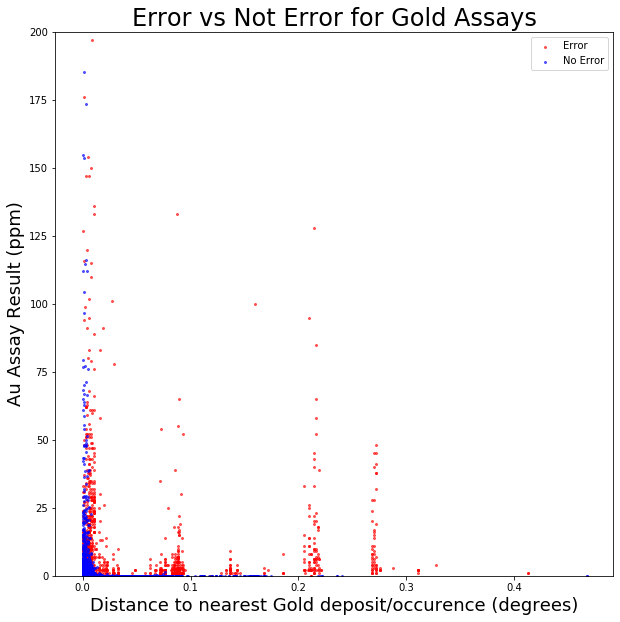

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,10]
plt.scatter(x = au_df[au_df['is_error'] == 1]['dist_to_occurence'],
            y = au_df[au_df['is_error'] == 1]['result'],
            color = 'red', alpha = 0.6, s = 4, label = 'Error')


plt.scatter(x = au_df[au_df['is_error'] == 0]['dist_to_occurence'],
            y = au_df[au_df['is_error'] == 0]['result'],
            color = 'blue', alpha = 0.6, s = 4, label = 'No Error')

plt.legend()
plt.title('Error vs Not Error for Gold Assays', fontsize = 24)
plt.xlabel('Distance to nearest Gold deposit/occurence (degrees)', fontsize = 18) 
plt.ylabel('Au Assay Result (ppm)', fontsize = 18)
_ = plt.ylim(0,200)

Clearly we see that when the gold result is really high but is an error, its far away from a gold occurence. This means that distance to a deposit is an important statistic to weeding out the Gold assays that may be small (eg 2ppm) but are incorrect.

Lets do a quick test on Gold results that are 20ppm 

In [51]:
au_test = tmp[((tmp['fixed_result'].isnull()) | (tmp['collar_name'] == 'MAC35')) &
    (tmp['ele'] == 'Au') &
    (tmp['result'] == 20)]

au_test.loc[:, 'is_error'] = np.where(au_test['result'] != au_test['fixed_result'], 1, 0).copy()

# Get back the lat/lons
au_test = au_test[['collar_id', 'collar_name',
       'result', 'fixed_result',
       'is_error']].merge(locs[['collar_id', 'lat', 'lon']],
                         validate = 'm:1')

# Convert into geopandas format
au_test = gpd.GeoDataFrame(au_test,
                      crs=latlon_crs,
                      geometry=[Point(xy) for xy in zip(au_test.lon, au_test.lat)])


# Get the minimum distance for each sample to each gold location
# Taking the min over axis 0 reduces it down to min dist for each sample
au_test['dists'] = gold.apply(lambda x: au_test.distance(x)).min(axis = 0).copy()

au_test

,collar_id,collar_name,result,fixed_result,is_error,lat,lon,geometry,dists
0,234726_SA,MAC35,20.0,-777.0,1,-32.561317,140.999317,POINT (140.999317 -32.5613166),0.206771
1,272864_SA,DP016,20.0,NaN,1,-29.717121,135.573824,POINT (135.5738239 -29.7171213),0.004012
2,273061_SA,DP006,20.0,NaN,1,-29.717310,135.571758,POINT (135.5717579 -29.7173103),0.005965


We have three results - MAC35 which is very far away from a gold occurence and DP016/DP006 which were drillholes into the Prominent Hill IOCG deposit (and verified to be correct).

So is the MAC35 assay correct?

Nope!

![title](img/mac35.png)

It appears that the Zinc assays in the source document are the gold assays in SARIG. Whats interesting is that it is the same company that found Challenger, so this error might have been skipped if the user noticed the company was Dominion and assumed this was related to Challenger.

In [34]:
tmp.loc[(tmp['collar_id'] == '234726_SA') &
    (tmp['result'] > 0) &
    (tmp['ele'] == 'Au'), 'fixed_result'] = -777

## 3.2 - Variance within Samples

Another way to check is for the variance within a single sample for an element. If there is the same interval that has a Gold assay of 100ppm and then 0.1ppm, its possible that an error has occured.

To calculate this:
- Group by each sample_id, and take the max and min for each element

To measure the variance, the difference or the ratio between the max and min can be taken. So far I've found that the ratio works better, because unit conversion errors can be easily found - If there are two Cu assays for a sample, and one is 1000 and one is incorrectly 1ppm, then the sample ratio will be exactly 1000.

In [35]:
sample_minmaxs = tmp.groupby(['sample_id', 'ele']).agg({'result' : [np.nanmax, np.nanmin]}).reset_index()
sample_minmaxs.columns = ['sample_id', 'ele', 'max', 'min']
sample_minmaxs['maxminratio'] = sample_minmaxs['max'] /sample_minmaxs['min']


# Put the maxminratio back into the main dataframe
tmp = tmp.merge(sample_minmaxs[['sample_id', 'ele', 'maxminratio']],
          how = 'left')

So what shows up when we check samples that have a max/min ratio of exactly 1000?

In [36]:
tmp[(tmp['fixed_result'].isnull())& (tmp['maxminratio'] == 1000)
   ].sort_values('maxminratio', ascending=False).iloc[0:500,0:20]

,collar_id,collar_name,max_depth,date_drilled,reference,sample_id,sample_source,from,to,ele,result,old_unit,method,isUDL,fixed_result,maxminratio
1334201,202280_SA,RC-DD03SH001,462.5,27/04/2003,NaN,929299_SA,Drill cuttings,104.0,110.0,Pb,4.5,ppb,ICP-OES,0,NaN,1000.0
1334218,202280_SA,RC-DD03SH001,462.5,27/04/2003,NaN,929299_SA,Drill cuttings,104.0,110.0,Pb,4500.0,ppm,ICP-MS,0,NaN,1000.0
2077804,206266_SA,RC-DD03WP003,148.3,07/04/2003,NaN,928363_SA,Drill cuttings,96.0,99.0,Pb,11500.0,ppm,ICP-OES,0,NaN,1000.0
2077821,206266_SA,RC-DD03WP003,148.3,07/04/2003,NaN,928363_SA,Drill cuttings,96.0,99.0,Pb,11.5,ppb,ICP-MS,0,NaN,1000.0


Only two assays show up, and it is apparent that the two samples have the unit conversion error between ppm/ppb.


What about a ratio of 100?

In [37]:
tmp[(tmp['fixed_result'].isnull())& (tmp['maxminratio'] == 100)
   ].sort_values('maxminratio', ascending=False).iloc[0:500,0:20]

,collar_id,collar_name,max_depth,date_drilled,reference,sample_id,sample_source,from,to,ele,result,old_unit,method,isUDL,fixed_result,maxminratio
865343,181510_SA,96ETAR 154,44.0,10/11/1996,ENV 09229,440023_SA,Drill cuttings,12.0,13.0,Ag,0.100,ppm,IC3M,0,NaN,100.0
865393,181510_SA,96ETAR 154,44.0,10/11/1996,ENV 09229,440023_SA,Drill cuttings,12.0,13.0,Ag,0.001,ppb,BLEG1C,0,NaN,100.0
876287,181532_SA,96ETAR 319,29.0,25/11/1996,ENV 09229,439997_SA,Drill cuttings,7.0,8.0,Ag,0.100,ppm,IC3M,0,NaN,100.0
876337,181532_SA,96ETAR 319,29.0,25/11/1996,ENV 09229,439997_SA,Drill cuttings,7.0,8.0,Ag,0.001,ppb,BLEG1C,0,NaN,100.0
2598708,214457_SA,KKRC070,208.0,04/10/2005,ENV 11109,1041266_SA,Drill cuttings,34.0,36.0,Mo,0.100,ppm,ARM3,0,NaN,100.0
2598714,214457_SA,KKRC070,208.0,04/10/2005,ENV 11109,1041266_SA,Drill cuttings,34.0,36.0,Mo,10.000,ppm,AA1R,0,NaN,100.0
3595430,229024_SA,KKRC101,147.0,14/05/2006,ENV 11335,1485262_SA,Drill cuttings,39.0,42.0,Mo,0.100,ppm,ARM3,0,NaN,100.0
3595436,229024_SA,KKRC101,147.0,14/05/2006,ENV 11335,1485262_SA,Drill cuttings,39.0,42.0,Mo,10.000,ppm,AA1R,0,NaN,100.0
9606773,284741_SA,WRD53,1009.0,03/04/2012,ENV 09288,2124844_SA,Drill core,685.0,686.0,Cu,200.000,%,IC1R,0,NaN,100.0
9606822,284741_SA,WRD53,1009.0,03/04/2012,ENV 09288,2124844_SA,Drill core,685.0,686.0,Cu,2.000,ppm,ME-4ACD81,0,NaN,100.0


The sample for WRD53 (Belonging to BHPs Wirrda Well deposit) is interesting - no other sample from the drilling program has a lab method of ME-4ACD81 and it cannot be found in the reference documents. This is also a copper assay with completely reasonable assay levels, so without using this 'variance within sample' metric, this discrepancy would probably stay hidden.

In [38]:
# Mark all the elements associated with that sample as wrong
tmp.loc[(tmp['method'] == 'ME-4ACD81') &
    (tmp['result'] > 0) &
    (tmp['collar_id'] == '284741_SA'), 'fixed_result'] = -777

# Rest are all good
tmp.loc[(tmp['method'] != 'ME-4ACD81') &
    (tmp['result'] > 0) &
    (tmp['collar_id'] == '284741_SA'), 'fixed_result'] = tmp.loc[(tmp['method'] != 'ME-4ACD81') &
                                            (tmp['result'] > 0) &
                                            (tmp['collar_id'] == '284741_SA'), 'result']


One downside of this variance within sample metric is that it detects a lot of samples where a follow up assay using a different assay technique has been used. Usually this different technique is done to measure some aspect of ore recovery so it can be quite different to the first assay - leading to high variance within the sample for an element.

## 3.3 Element Means for Drill Hole


We noticed that column swapping and misalignment can be a potential issue - So far I've stumbled upon them because the column swap causes something like Gold or Platinum, elements that tradionally have very low values, to have exceptionally high values.

How can we attempt to target these data entry errors? If columns have swapped or become misaligned, it may mean that one drill hole will have higher than normal values for one element, and another one will have lower than normal values.

To be able to compare different elements, the following is done.

- Take the median value for that element from the entire database
- Take the median value for that element for a drillhole
- Divide the maximum of those two values by the minimum of those two values
    - Why? We dont care if an element is smaller or larger than its typical values, we just want to know that its different
    - Downsides to dividing? Elements where the median is 0 (very low trace elements) will divide by zero
 
 

 

In [39]:
# Get the median value for each element
ele_med = tmp.groupby('ele')['result'].median().reset_index()
ele_med.columns = ['ele', 'ele_medians']

# Get the median value for each element in each drillhole
dh_ele_med = tmp.groupby(['collar_id', 'ele']).agg({'result': [len, np.nanmedian]}).reset_index()
dh_ele_med.columns = ['collar_id', 'ele', 'sample_counts','dh_ele_med']

# Merge the two tables
dh_ele_med = dh_ele_med.merge(ele_med)

# Calculate the ratio of the two values
dh_ele_med['median_ratio'] = np.where(dh_ele_med['dh_ele_med'] > dh_ele_med['ele_medians'],
                                      dh_ele_med['dh_ele_med'] / dh_ele_med['ele_medians'],
                                      dh_ele_med['ele_medians'] /dh_ele_med['dh_ele_med'])

# Filter the table
# Drop the rows where the ratio is 0 of infinite
# Drop the rows where the drillhole has less than 20 samples
# Drop the rows where we have already detected errors (we want to find new errors!)
dh_ele_med = dh_ele_med[(dh_ele_med['sample_counts'] > 20) &
                       ~(dh_ele_med['median_ratio'].isnull()) & (dh_ele_med['median_ratio'] > 0) &
                       (dh_ele_med['median_ratio'] != np.inf) &
                       ~(dh_ele_med['collar_id'].isin(tmp[~tmp['fixed_result'].isnull()]['collar_id'].unique()))]

The next step is to simply pick a threshold for the ratio, and count how many elements exceed the ratio for each drillhole.

A lot of the errors that show up with this method are data releases where the typical % assays (Mg,Fe,Ca, Na, K, Ti) are off by a factor of 10000 - one of these is shown below.

In [40]:
dh_ele_med[dh_ele_med['collar_id'] == '325470_SA']

,collar_id,ele,sample_counts,dh_ele_med,ele_medians,median_ratio
33294,325470_SA,Ag,25.0,0.290,0.200000,1.450000
84537,325470_SA,Au,25.0,0.002,0.005000,2.500000
137565,325470_SA,Cu,25.0,783.000,39.000000,20.076923
185413,325470_SA,Pb,25.0,3.500,10.000000,2.857143
234239,325470_SA,Zn,25.0,195.000,40.000000,4.875000
252451,325470_SA,Ca,25.0,1.790,7457.000000,4165.921788
268679,325470_SA,K,25.0,0.250,15440.810227,61763.240910
285977,325470_SA,Mg,25.0,6.430,9200.000000,1430.793157
300017,325470_SA,Na,25.0,0.650,2522.255193,3880.392604
325353,325470_SA,Co,25.0,90.200,18.000000,5.011111


So for the elements with high difference of their median to the typical element median, are they legit outliers or data entry errors?

- S is correct, Th is correct
- Ti, Al, Na, Mg, K, Ca are off by 10000 (source says ppm but it has to be %, based on the MS61 assay specs from ALS saying that minimum ppm is 100, backed up by source documents below)

![nicui](img/nicui.png)



In [41]:
# Fix the percentage errors
tmp.loc[(tmp['collar_id'] == '325470_SA') &
    (tmp['ele'].isin(['Ti', 'Al', 'Na', 'Mg', 'K', 'Ca'])) &
    (tmp['result'] > 0 ), 'fixed_result'] = tmp.loc[(tmp['collar_id'] == '325470_SA') &
                                (tmp['ele'].isin(['Ti', 'Al', 'Na', 'Mg', 'K', 'Ca'])) &
                                (tmp['result'] > 0 ), 'fixed_result'] * 10000


# Carry over the rest
tmp.loc[(tmp['collar_id'] == '325470_SA') &
    ~(tmp['ele'].isin(['Ti', 'Al', 'Na', 'Mg', 'K', 'Ca'])) &
    (tmp['result'] > 0 ), 'fixed_result'] = tmp.loc[(tmp['collar_id'] == '325470_SA') &
                               ~ (tmp['ele'].isin(['Ti', 'Al', 'Na', 'Mg', 'K', 'Ca'])) &
                                (tmp['result'] > 0 ), 'fixed_result']

This method is really good for identifying the errors with percentage <-> ppm <-> ppb conversion errors, but the goal is to hunt for column misalignment errors.

To do this, I excluded the typical elements that have the %/ppm conversion errors, and found this drill hole that had 4 elements with a median ratio over 400.

In [42]:
dh_ele_med[dh_ele_med['collar_id'] == '206200_SA']

,collar_id,ele,sample_counts,dh_ele_med,ele_medians,median_ratio
12215,206200_SA,Ag,46.0,0.350000,0.200000,1.750000
106872,206200_SA,Cu,46.0,91.900000,39.000000,2.356410
156853,206200_SA,Pb,46.0,35.100000,10.000000,3.510000
240928,206200_SA,Ca,46.0,10640.681004,7457.000000,1.426939
257185,206200_SA,K,46.0,21874.481156,15440.810227,1.416667
273657,206200_SA,Mg,46.0,20715.233386,9200.000000,2.251656
290309,206200_SA,Na,46.0,12870.919881,2522.255193,5.102941
310393,206200_SA,Co,46.0,29.850000,18.000000,1.658333
334390,206200_SA,Mo,46.0,3.300000,1.100000,3.000000
359926,206200_SA,Ni,92.0,65.000000,18.400000,3.532609


So whats up with this hole?

- The S median for this drill hole is 480 times smaller than typical values
- The Tm median is 680 times larger than typical values
- The Nd median is 1139 times smaller than typical values

Investigation shows that it belongs to the ENV09877 Data release, and the data disitrubtion (Very low Nd, Very High S, very High Tm), happens to all holes. When looking at the reference data, theres a lot going on in terms of data entry errors.

![9877](img/9877.png)

Nd is a unit conversion error - its off by a factor of 1000.

Then for <i>some</i> samples, theres a column misalignment error. When the Pd/Pt assays are not present, the elements shift over, causing Pd to have the Pr values and Rb to have the Sb values, etc etc.

So using the method of finding drillholes with a high amount of elements with drill hole medians significantly different than the typical median, we were able to identify a report with column misalignment errors, and potentially a lot faster than the method of looking at one elements one by one.



In [43]:
tmp.loc[(tmp['collar_name'].str.startswith('BLRC')) &
        (tmp['ele'] == 'Nd'), 'fixed_result' ] = tmp.loc[(tmp['collar_name'].str.startswith('BLRC')) &
                                                (tmp['ele'] == 'Nd'), 'result'] * 1000


bad_eles = ['Pd','Pr','Pt','Rb','S','Sb','Sc',
            'Si','Sm','Sn', 'Sr', 'Ta', 'Tb',
            'Th', 'Ti', 'Tl', 'Tm', 'U',
            'V', 'W', 'Y', 'Yb', 'Zn', 'Zr']

bad_samples = tmp.loc[(tmp['collar_name'].str.startswith('BLRC')) &
        (tmp['ele'] == 'Sn') &
        (tmp['result'] > 80 ) &
        (tmp['fixed_result'].isnull())]['sample_id']



tmp.loc[(tmp['collar_name'].str.startswith('BLRC')) &
        (tmp['sample_id'].isin(bad_samples)) &
        (tmp['ele'].isin(bad_eles)) &
        (tmp['fixed_result'].isnull())] = -777

tmp.loc[(tmp['collar_name'].str.startswith('BLRC'))  &
        (tmp['fixed_result'].isnull()), 'fixed_result'] = tmp.loc[(tmp['collar_name'].str.startswith('BLRC'))  &
                                                            (tmp['result'].isnull()), 'result']

# Section Four - Summary

I spent 5 solid days looking through the geochemistry database, hunting down the mistakes. While general mistakes can be quick to spot when just sorting by the assay result values, it takes a lot of time to understand the extent of errors within a data release.

How much of the geochem database have we actually checked? And how many errors have we found?

In [44]:
print('Number of Records Checked: ',(~tmp['fixed_result'].isnull()).sum())
print('Total number of assays: ', len(tmp))
print('% Checked: ', ((~tmp['fixed_result'].isnull()).sum() / len(tmp) * 100))

Number of Records Checked:  613615
Total number of assays:  25874780
% Checked:  2.3714791004986324


So only 2.37% of the database has been inspected for errors after 5 days of verifying records.


### Root Causes

What are the root causes of the data entry errors found so far?

-<b> Unit Conversion Errors:</b> eg When the assay has its units still listed as % but its already been converted into ppm

-<b> Column Misalignment:</b> Often caused by some repeat assays or a blank column within the reference document, the column headers become misaligned, causing results of the elements to be aligned to the wrong element
    
    
-<b> Misspelling of Elements: </b>This was only spotted once, but occured when the Pd assay had the last letter cut off, causing the assays to fall under the P element


### Strategies to Detect Errors

There are four methods that I've employed to hunt down errors. Each of them have their pros and cons.

- Sort an Element from high to low
    - Pros: Finds the most obvious errors
    - Cons: Lots of false positives from high assay results that come from mine sites

- Distance to Deposit/Occurence
    - Pros: Very efficient at finding hard to detect errors
    - Cons: Takes a while to calculate, not applicable to every error

- Sample Variance
    - Pros: Easy to detect unit conversion errors
    - Cons: Picks up a lot of false positives of where the sample was assayed again using a different technique

- Drillhole Element Median Ratios
    - Pros: Really good at detecting errors that have been caused by column misalignment errors
    - Cons: Cant use it for the trace elements that have their median value as 0

It is simply not feasible to check all the errors (I haven't even looked at surface sampling!), so there is always a trade off between time and effectiveness - dont waste time fixing assays for Silicon if you are working on some Gold analysis. 

My suggestion is that if you are only working with one element, employ the first two techniques to get rid of as many obvious errors that can completely mess up whatever machine learning/ data science approach you are using. Then start looking at Sample Variances and Drillhole Element Medians to detect more errors.


### Save the dataset

Only the assays have changed, so we keep the original sample and collar dataframes, and get the updated assay date.

In [55]:
assays_v2 = tmp[['sample_id', 'ele', 'result', 'old_unit', 'method', 'fixed_result', 'isUDL']].reset_index(drop=True)

assays_v2.to_csv('sa_assays.csv', index=False)
samples.to_csv('sa_samples.csv', index=False)
locs.to_csv('sa_collars.csv', index=False)

# Bonus - .....machine learning?


Originally when I started the notebook, the original aim was to use machine learning to hunt down the hard to detect errors, and to do it faster. However after 5 days of data cleaning, I still wasn't close to getting rid of the easy to detect errors (eg obvious unit conversion errors and column misalignments), so the business value of a machine learning approach over just data analysis techniques was not worth it - its just faster to manually search for these obvious errors.


I still think a ML approach would be valuable once all the low hanging fruit is done, so how would you go about doing a machine learning approach? Well because I've been marking assays as error/not error, we now have a dataset that can be used to training a model as follows:

![title](img/ml_process.png)

What would be the advantages of machine learning? We can start incorporating lots of different features, which will ultimately allow us to weed out every single error. What are some of the features we could include?

- Was the assay done by pXRF? - pXRF can cause some funky results due to miscalibration, but these are generally not data entry errors. So a ML model could potentially figure out that if a result for an element is strange but from XRF assay methods, its probably legit.
- Distance to deposit: As has been established, distance to deposit is a good metric for establishing data entry errors
- What year was the assay from? -  A lot of the old assays have assay methods that have less precision/accuracy, but are still legitimate assays
- What unit was the element assayed? - If you have an assay of Iron or Silicon in ppb, this would be a red flag
- What drilling method was used? - Shallow Aircore holes are generally going to have a different element distribution than deep diamond drilling

So stay tuned, as I still plan to explore this eventually.

Thanks for reading!

Michael Rodda


![logo](img/logov2.png)
<center>www.caldera.technology</center>

